# 1. Data Loading and Initial Analysis

In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [ ]:
import pandas as pd

train_df = pd.read_csv("data/train_set.csv")
test_df = pd.read_csv("data/test_set.csv")

print("Null values in train_df:")
print(train_df.isnull().sum())

print("\nNull values in test_df:")
print(test_df.isnull().sum())

Null values in train_df:
text         0
sentiment    0
dtype: int64

Null values in test_df:
text         0
sentiment    0
dtype: int64


In [ ]:
print("Train dataset length:", len(train_df))
print("Eval dataset length:", len(test_df))

Train dataset length: 40000
Eval dataset length: 10000


# 2. Tokenization, Data Collation, Cross-Validation and Hyperparameter Tuning

In [ ]:
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
import evaluate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

train_df = pd.read_csv("data/train_set.csv")
test_df = pd.read_csv("data/test_set.csv")

full_dataset = Dataset.from_pandas(train_df).rename_column("sentiment", "labels")
test_dataset = Dataset.from_pandas(test_df).rename_column("sentiment", "labels")

# 2. Initialize tokenizer with dynamic padding
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
    )

full_dataset = full_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 3. Configure metrics (load separately to avoid passing average to accuracy)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute each metric separately
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1_val = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    prec = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
    rec = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]

    return {
        "accuracy": acc,
        "f1": f1_val,
        "precision": prec,
        "recall": rec
    }

# 4. Cross-validation and hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
hyperparams = {
    "learning_rates": [2e-5, 3e-5],
    "batch_sizes": [16]
}

best_params = {}
best_score = 0
final_cm = None

for lr in hyperparams["learning_rates"]:
    for bs in hyperparams["batch_sizes"]:
        print(f"\n{'='*40}")
        print(f"Testing LR: {lr}, Batch Size: {bs}")
        print(f"{'='*40}")

        fold_metrics = []
        fold_cms = []

        texts = full_dataset["text"]
        labels = full_dataset["labels"]

        for fold, (train_idx, val_idx) in enumerate(cv.split(texts, labels)):
            print(f"\nFold {fold+1}/5")

            try:
                # Data splitting
                train_subset = full_dataset.select(train_idx)
                val_subset = full_dataset.select(val_idx)

                # Model initialization
                model = DistilBertForSequenceClassification.from_pretrained(
                    model_name, num_labels=2
                )

                # Training arguments
                training_args = TrainingArguments(
                    output_dir=f"./cv_results/lr_{lr}_bs_{bs}_fold_{fold+1}",
                    evaluation_strategy="epoch",
                    save_strategy="epoch",
                    learning_rate=lr,
                    per_device_train_batch_size=bs,
                    per_device_eval_batch_size=bs,
                    num_train_epochs=3,
                    weight_decay=0.01,
                    load_best_model_at_end=True,
                    metric_for_best_model="f1",
                    logging_steps=50,
                    report_to="none",
                    seed=42,
                    fp16=True,
                )

                # Trainer setup
                trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=train_subset,
                    eval_dataset=val_subset,
                    compute_metrics=compute_metrics,
                    data_collator=data_collator,
                )

                # Training and evaluation
                trainer.train()
                eval_results = trainer.evaluate()

                # Store metrics
                fold_metrics.append(eval_results)

                # Generate predictions for confusion matrix
                predictions = trainer.predict(val_subset)
                y_true = predictions.label_ids
                y_pred = np.argmax(predictions.predictions, axis=1)
                fold_cms.append(confusion_matrix(y_true, y_pred))

            except Exception as e:
                print(f"Error in fold {fold+1}: {str(e)}")
                continue

            finally:
                del model
                torch.cuda.empty_cache()

        # Calculate average performance across folds
        if len(fold_metrics) > 0:
            avg_f1 = np.mean([m["eval_f1"] for m in fold_metrics])
        else:
            avg_f1 = float("nan")

        print(f"\nAverage Validation F1: {avg_f1:.4f}")

        # Update best parameters
        if not np.isnan(avg_f1) and avg_f1 > best_score:
            best_score = avg_f1
            best_params = {"lr": lr, "batch_size": bs}
            final_cm = np.sum(fold_cms, axis=0)

# 5. Final training on entire dataset with best hyperparams
print(f"\n{'='*40}")
print(f"Final Training with Best Parameters:")
print(f"Learning Rate: {best_params.get('lr', 'N/A')}")
print(f"Batch Size: {best_params.get('batch_size', 'N/A')}")
print(f"{'='*40}")

final_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
final_args = TrainingArguments(
    output_dir="./final_model",
    learning_rate=best_params.get('lr', 1e-5),
    per_device_train_batch_size=best_params.get('batch_size', 16),
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    report_to="none",
    seed=42,
    fp16=True,
    evaluation_strategy="no",
    save_strategy="no",
)

trainer = Trainer(
    model=final_model,
    args=final_args,
    train_dataset=full_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

# Save final model
trainer.save_model("./fine_tuned_distilbert_model")
tokenizer.save_pretrained("./fine_tuned_distilbert_model")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


Testing LR: 2e-05, Batch Size: 16

Fold 1/5


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.272600,0.241712,0.903000,0.905320,0.884175,0.927500
2,0.154500,0.290289,0.907875,0.909957,0.889845,0.931000
3,0.148200,0.353283,0.913125,0.913417,0.910355,0.916500



Fold 2/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.250500,0.238225,0.906000,0.907888,0.890010,0.926500
2,0.200300,0.251278,0.915500,0.913995,0.930570,0.898000
3,0.108300,0.340071,0.915000,0.914271,0.922177,0.906500



Fold 3/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.232000,0.246548,0.907750,0.909934,0.888889,0.932000
2,0.160300,0.290179,0.915375,0.912859,0.940833,0.886500
3,0.137900,0.314963,0.919375,0.918817,0.925222,0.912500



Fold 4/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.259200,0.251334,0.900500,0.895921,0.939145,0.856500
2,0.163200,0.262187,0.916625,0.916489,0.917983,0.915000
3,0.102100,0.353066,0.913625,0.912830,0.921314,0.904500



Fold 5/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.276600,0.236622,0.904750,0.908457,0.874422,0.945250
2,0.180300,0.273184,0.915875,0.918057,0.894849,0.942500
3,0.104300,0.318249,0.917625,0.917450,0.919407,0.915500



Average Validation F1: 0.9162

Testing LR: 3e-05, Batch Size: 16

Fold 1/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.264900,0.231673,0.910750,0.912220,0.897436,0.927500
2,0.128500,0.289357,0.915875,0.916615,0.908622,0.924750
3,0.084500,0.366291,0.917125,0.917568,0.912689,0.922500



Fold 2/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.249900,0.236478,0.911500,0.912224,0.904820,0.919750
2,0.178900,0.262823,0.915750,0.912694,0.947043,0.880750
3,0.075500,0.354081,0.918375,0.918160,0.920583,0.915750



Fold 3/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.227400,0.241008,0.911000,0.911597,0.905525,0.917750
2,0.136900,0.291486,0.915625,0.913450,0.937615,0.890500
3,0.123300,0.343332,0.918125,0.917308,0.926549,0.908250



Fold 4/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.256100,0.240438,0.904750,0.901116,0.936859,0.868000
2,0.150100,0.269341,0.917125,0.918178,0.906654,0.930000
3,0.084700,0.379205,0.912125,0.911427,0.918720,0.904250



Fold 5/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.265800,0.252229,0.899125,0.904824,0.856441,0.959000
2,0.167900,0.265781,0.917375,0.919321,0.898164,0.941500
3,0.093900,0.346886,0.916625,0.916739,0.915482,0.918000



Average Validation F1: 0.9181

Final Training with Best Parameters:
Learning Rate: 3e-05
Batch Size: 16


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
100,0.541900
200,0.384600
300,0.358400
400,0.336500
500,0.342800
600,0.297500
700,0.304900
800,0.328200
900,0.275300
1000,0.294700


### Note: Due to Colab resource limits, the entire cross‑validation process completed but the subsequent best parameter training did not complete in one run. Therefore, the best parameter training was done seperately in the cell below.

Additionally we were only able to compare 2 learning rates.

========================================

Final Training with Best Parameters:

Learning Rate: 3e-05

Batch Size: 16

========================================

# 3. Final Training on Full Dataset with Best Hyperparameters (Skip if you have sufficient resources to run the previous cell fully)


In [ ]:
train_df = pd.read_csv("data/train_set.csv")
full_dataset = Dataset.from_pandas(train_df).rename_column("sentiment", "labels")

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
    )

full_dataset = full_dataset.map(tokenize_function, batched=True)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1_val = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    prec = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
    rec = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]
    return {"accuracy": acc, "f1": f1_val, "precision": prec, "recall": rec}

# Final training on the full dataset using the best hyperparameters
final_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
final_args = TrainingArguments(
    output_dir="./final_model",
    learning_rate=3e-05,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    report_to="none",
    seed=42,
    fp16=True,
    evaluation_strategy="no",
    save_strategy="no",
)

trainer = Trainer(
    model=final_model,
    args=final_args,
    train_dataset=full_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Train the final model
trainer.train()

# Save the final model and tokenizer
trainer.save_model("./fine_tuned_distilbert_model")
tokenizer.save_pretrained("./fine_tuned_distilbert_model")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
100,0.523900
200,0.385400
300,0.362100
400,0.324200
500,0.331400
600,0.295500
700,0.325800
800,0.347000
900,0.273500
1000,0.294900


('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json',
 './final_model/tokenizer.json')

# 4. Test Set Evaluation and Visualization


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


Final Test Evaluation:



Classification Metrics:
              precision    recall  f1-score   support

    negative       0.92      0.92      0.92      5000
    positive       0.92      0.92      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


Confusion Matrix:


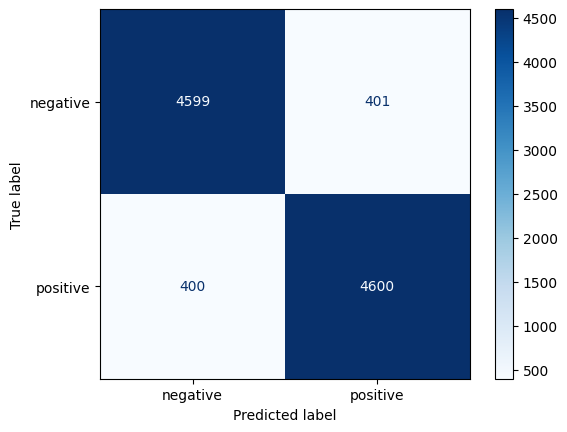

In [ ]:
test_df = pd.read_csv("data/test_set.csv")
test_dataset = Dataset.from_pandas(test_df).rename_column("sentiment", "labels")

test_dataset = test_dataset.map(tokenize_function, batched=True)

print("\nFinal Test Evaluation:")
test_results = trainer.evaluate(test_dataset)

# Generate predictions
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Classification report
print(f"\n{'='*40}")
print("Classification Metrics:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

# Confusion matrix visualization
print(f"\n{'='*40}")
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),
                              display_labels=["negative", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 5. Example prediction

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(device)

sample_text = "I have never seen such a captivating movie before, it is as thought-provoking as my favourite module IT1244!"
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

with torch.no_grad():
    outputs = final_model(**inputs)
prediction = torch.argmax(outputs.logits, dim=1).item()
print(f"Sample Prediction: {sample_text}")
print(f"Predicted Sentiment: {'positive' if prediction == 1 else 'negative'}")

Sample Prediction: I have never seen such a captivating movie before, it is as thought-provoking as my favourite module IT1244!
Predicted Sentiment: positive


# Run the saved model

In [2]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

model_path = "./fine_tuned_distilbert_model"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

sample_text = "THIS movie is so good!"
inputs = tokenizer(
    sample_text,
    return_tensors="pt",
    truncation=True,
    max_length=512
)

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

sentiment = "positive" if predicted_class == 1 else "negative"
print(f"Text: {sample_text}")
print(f"Predicted Sentiment: {sentiment}")


Text: THIS movie is so good!
Predicted Sentiment: positive
